In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from models import StochasticVolatilityModel, generate_data
from filters import ExtendedKalmanFilter, UnscentedKalmanFilter, ParticleFilter

In [9]:
class NonKalmanExperiment:
    """
    Class for running non-Kalman filter experiments with standardized plotting methods.
    
    Inputs:
        model: StateSpaceModel instance
        T: Number of time steps
        random_state: numpy random generator, optional
    """
    
    def __init__(self, model, T=500, random_state=None):
        self.model = model
        self.T = T
        self.random_state = random_state if random_state is not None else np.random.default_rng(42)
        
        # State dimension
        self.nx = model.state_dim
        
        # Initialize flags
        self._data_generated = False
        self._filters_run = {}
        
        # Initialize storage variables
        self.true_states = None
        self.observations = None
        self.filter_results = {}  # Store results for each filter: {name: {'means': ..., 'covs': ..., 'filter': ..., 'errors': ..., 'error_norms': ..., 'uncertainty_norms': ...}}
    
    def generate_data(self):
        """Generate true states and observations from the model."""
        from models import generate_data
        self.true_states, self.observations = generate_data(self.model, self.T, self.random_state)
        self._data_generated = True
    
    def get_observations(self):
        """Return observations."""
        if not self._data_generated:
            raise ValueError("Data must be generated first. Call generate_data().")
        return self.observations
    
    def run_filter(self, filter_instance, filter_name):
        """
        Run a filter on the observations.
        
        Args:
            filter_instance: Filter instance (EKF, UKF, PF, etc.)
            filter_name: Name/label for this filter (e.g., 'EKF', 'UKF', 'PF')
        """
        if not self._data_generated:
            raise ValueError("Data must be generated first. Call generate_data() before run_filter().")
        
        if not hasattr(filter_instance, 'filter'):
            raise ValueError(f"Filter {filter_name} does not have a filter() method.")
        
        # Run filter (handles different filter interfaces)
        # Try with random_state first (for ParticleFilter, Flow filters)
        try:
            means, covs = filter_instance.filter(self.observations, random_state=self.random_state)
        except TypeError:
            # If that fails, try without random_state (for EKF, UKF)
            try:
                means, covs = filter_instance.filter(self.observations)
            except Exception as e:
                raise ValueError(f"Failed to run filter {filter_name}: {e}")
        
        # Compute errors
        errors = means - self.true_states
        error_norms = np.linalg.norm(errors, axis=1)
        uncertainty_norms = np.sqrt(np.trace(covs, axis1=1, axis2=2))
        
        # Store results
        self.filter_results[filter_name] = {
            'means': means,
            'covs': covs,
            'filter': filter_instance,
            'errors': errors,
            'error_norms': error_norms,
            'uncertainty_norms': uncertainty_norms
        }
        self._filters_run[filter_name] = True
    
    def create_and_run_ekf(self, filter_name='EKF', **kwargs):
        """
        Create and run Extended Kalman Filter.
        
        Args:
            filter_name: Name for this filter instance
            **kwargs: Additional arguments passed to ExtendedKalmanFilter (currently none)
        """
        from filters import ExtendedKalmanFilter
        ekf = ExtendedKalmanFilter(self.model, **kwargs)
        self.run_filter(ekf, filter_name)
    
    def create_and_run_ukf(self, filter_name='UKF', alpha=1e-3, beta=2.0, kappa=0.0, **kwargs):
        """
        Create and run Unscented Kalman Filter.
        
        Args:
            filter_name: Name for this filter instance
            alpha: Spread parameter for sigma points (default 1e-3)
            beta: Incorporates prior knowledge (default 2.0)
            kappa: Secondary scaling parameter (default 0.0)
            **kwargs: Additional arguments passed to UnscentedKalmanFilter
        """
        from filters import UnscentedKalmanFilter
        ukf = UnscentedKalmanFilter(self.model, alpha=alpha, beta=beta, kappa=kappa, **kwargs)
        self.run_filter(ukf, filter_name)
    
    def create_and_run_pf(self, filter_name='PF', n_particles=1000, resample_threshold=0.5, 
                          n_threads=None, **kwargs):
        """
        Create and run Particle Filter.
        
        Args:
            filter_name: Name for this filter instance
            n_particles: Number of particles (default 1000)
            resample_threshold: Resample when ESS/N < threshold (default 0.5)
            n_threads: Number of threads for parallelization (default: CPU count, None = no threading)
            **kwargs: Additional arguments passed to ParticleFilter
        """
        from filters import ParticleFilter
        pf = ParticleFilter(self.model, n_particles=n_particles, 
                           resample_threshold=resample_threshold, n_threads=n_threads, **kwargs)
        self.run_filter(pf, filter_name)
    
    def plot1_true_vs_estimated_with_confidence(self, filter1=None, filter2=None, filter3=None, 
                                                 filter1_name=None, filter2_name=None, filter3_name=None,
                                                 t_min=None, t_max=None, step_size=1):
        """
        Plot 1: True vs Estimated states with confidence level (error bar version).
        Works only for 1D data. Can compare up to 3 filters.
        
        Args:
            filter1, filter2, filter3: Filter names for MEAN estimates (keys in filter_results)
            filter1_name, filter2_name, filter3_name: Filter names for UNCERTAINTY (keys in filter_results).
                                                     If None, uses the same filter as the mean.
            t_min: Minimum time step to plot (default: 0)
            t_max: Maximum time step to plot (default: T)
            step_size: Step size between neighbor points in time (default: 1, plot all points)
        """
        if self.nx != 1:
            raise ValueError("Plot 1 only works for 1D data (state_dim = 1)")
        
        # Build list of (mean_filter, uncertainty_filter, color) tuples
        filters_to_plot = []
        colors = ['b', 'r', 'g']
        
        for f_mean, f_unc, c in zip([filter1, filter2, filter3], 
                                    [filter1_name, filter2_name, filter3_name],
                                    colors):
            if f_mean is not None and f_mean in self.filter_results:
                # If uncertainty filter not specified, use same as mean
                f_unc = f_mean if f_unc is None else f_unc
                if f_unc not in self.filter_results:
                    raise ValueError(f"Uncertainty filter '{f_unc}' not found in filter_results.")
                filters_to_plot.append((f_mean, f_unc, c))
        
        if len(filters_to_plot) == 0:
            raise ValueError("At least one filter must be specified and run.")
        
        # Set time range
        t_min = 0 if t_min is None else max(0, int(t_min))
        t_max = self.T if t_max is None else min(self.T, int(t_max))
        if t_min >= t_max:
            raise ValueError(f"t_min ({t_min}) must be less than t_max ({t_max})")
        
        step_size = max(1, int(step_size))  # Ensure step_size is at least 1
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        time_steps = np.arange(t_min, t_max)[::step_size]
        
        # Plot true state (sliced and downsampled)
        ax.plot(time_steps, self.true_states[t_min:t_max:step_size, 0], 'k-', label='True state', linewidth=2.5)
        
        # Plot each filter
        for f_mean, f_unc, color in filters_to_plot:
            # Get mean from mean filter
            result_mean = self.filter_results[f_mean]
            means = result_mean['means'][t_min:t_max:step_size]
            
            # Get uncertainty from uncertainty filter
            result_unc = self.filter_results[f_unc]
            covs = result_unc['covs'][t_min:t_max:step_size]
            
            # Extract standard deviation
            if covs.shape[1] == 1:
                std = np.sqrt(covs[:, 0, 0])
            else:
                std = np.sqrt(np.trace(covs, axis1=1, axis2=2))
            
            # Display name: show both if different, otherwise just one
            if f_mean == f_unc:
                display_name = f_mean
            else:
                display_name = f'{f_mean} (mean), {f_unc} (unc)'
            
            ax.plot(time_steps, means[:, 0], '--', color=color, label=display_name, linewidth=1.5, alpha=0.8)
            ax.fill_between(
                time_steps,
                means[:, 0] - 2*std,
                means[:, 0] + 2*std,
                alpha=0.2, color=color, label=f'{display_name} ±2σ'
            )
        
        ax.set_xlabel('Time Step', fontsize=12)
        ax.set_ylabel('State', fontsize=12)
        ax.set_title('True vs Estimated State with Confidence Intervals', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot2_true_vs_estimated_with_observations(self, filter1=None, filter2=None, filter3=None,
                                                   filter1_name=None, filter2_name=None, filter3_name=None,
                                                   t_min=None, t_max=None, step_size=1):
        """
        Plot 2: True vs Estimated states with observations.
        Works only for 1D data. Can compare up to 3 filters.
        
        Args:
            filter1, filter2, filter3: Filter names for MEAN estimates (keys in filter_results)
            filter1_name, filter2_name, filter3_name: Filter names for UNCERTAINTY (keys in filter_results).
                                                     If None, uses the same filter as the mean.
            t_min: Minimum time step to plot (default: 0)
            t_max: Maximum time step to plot (default: T)
            step_size: Step size between neighbor points in time (default: 1, plot all points)
        """
        if self.nx != 1:
            raise ValueError("Plot 2 only works for 1D data (state_dim = 1)")
        
        # Build list of (mean_filter, uncertainty_filter, color) tuples
        filters_to_plot = []
        colors = ['b', 'r', 'g']
        
        for f_mean, f_unc, c in zip([filter1, filter2, filter3], 
                                    [filter1_name, filter2_name, filter3_name],
                                    colors):
            if f_mean is not None and f_mean in self.filter_results:
                # If uncertainty filter not specified, use same as mean
                f_unc = f_mean if f_unc is None else f_unc
                if f_unc not in self.filter_results:
                    raise ValueError(f"Uncertainty filter '{f_unc}' not found in filter_results.")
                filters_to_plot.append((f_mean, f_unc, c))
        
        if len(filters_to_plot) == 0:
            raise ValueError("At least one filter must be specified and run.")
        
        # Set time range
        t_min = 0 if t_min is None else max(0, int(t_min))
        t_max = self.T if t_max is None else min(self.T, int(t_max))
        if t_min >= t_max:
            raise ValueError(f"t_min ({t_min}) must be less than t_max ({t_max})")
        
        step_size = max(1, int(step_size))  # Ensure step_size is at least 1
        
        fig, ax = plt.subplots(1, 1, figsize=(14, 6))
        time_steps = np.arange(t_min, t_max)[::step_size]
        
        # Plot observations (sliced and downsampled)
        ax.plot(time_steps, self.observations[t_min:t_max:step_size, 0], 'rp', label='Observations', markersize=5, alpha=1)
        
        # Plot true state (sliced and downsampled)
        ax.plot(time_steps, self.true_states[t_min:t_max:step_size, 0], 'k-', label='True state', linewidth=2)
        
        # Plot each filter
        for f_mean, f_unc, color in filters_to_plot:
            # Get mean from mean filter
            result_mean = self.filter_results[f_mean]
            means = result_mean['means'][t_min:t_max:step_size]
            
            # Display name: show both if different, otherwise just one
            if f_mean == f_unc:
                display_name = f_mean
            else:
                display_name = f'{f_mean} (mean), {f_unc} (unc)'
            
            ax.plot(time_steps, means[:, 0], '--', color=color, label=display_name, linewidth=1.5, alpha=0.8)
        
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
        ax.set_title('Observations vs True/Estimated State')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot3_absolute_error_with_2sigma(self, filter1=None, filter2=None, filter3=None,
                                        filter1_name=None, filter2_name=None, filter3_name=None,
                                        t_min=None, t_max=None, step_size=1):
        """
        Plot 3: Absolute error with 2 sigma bound.
        Works for any dimension. Can compare up to 3 filters.
        
        Args:
            filter1, filter2, filter3: Filter names for ERROR NORMS (keys in filter_results)
            filter1_name, filter2_name, filter3_name: Filter names for UNCERTAINTY NORMS (keys in filter_results).
                                                     If None, uses the same filter as the error.
            t_min: Minimum time step to plot (default: 0)
            t_max: Maximum time step to plot (default: T)
            step_size: Step size between neighbor points in time (default: 1, plot all points)
        """
        # Build list of (error_filter, uncertainty_filter, color) tuples
        filters_to_plot = []
        colors = ['b', 'r', 'g']
        
        for f_err, f_unc, c in zip([filter1, filter2, filter3], 
                                    [filter1_name, filter2_name, filter3_name],
                                    colors):
            if f_err is not None and f_err in self.filter_results:
                # If uncertainty filter not specified, use same as error
                f_unc = f_err if f_unc is None else f_unc
                if f_unc not in self.filter_results:
                    raise ValueError(f"Uncertainty filter '{f_unc}' not found in filter_results.")
                filters_to_plot.append((f_err, f_unc, c))
        
        if len(filters_to_plot) == 0:
            raise ValueError("At least one filter must be specified and run.")
        
        # Set time range
        t_min = 0 if t_min is None else max(0, int(t_min))
        t_max = self.T if t_max is None else min(self.T, int(t_max))
        if t_min >= t_max:
            raise ValueError(f"t_min ({t_min}) must be less than t_max ({t_max})")
        
        step_size = max(1, int(step_size))  # Ensure step_size is at least 1
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        time_steps = np.arange(t_min, t_max)[::step_size]
        
        # Plot each filter
        for f_err, f_unc, color in filters_to_plot:
            # Get error norms from error filter
            result_err = self.filter_results[f_err]
            error_norms = result_err['error_norms'][t_min:t_max:step_size]
            
            # Get uncertainty norms from uncertainty filter
            result_unc = self.filter_results[f_unc]
            uncertainty_norms = result_unc['uncertainty_norms'][t_min:t_max:step_size]
            
            # Display name: show both if different, otherwise just one
            if f_err == f_unc:
                display_name = f_err
            else:
                display_name = f'{f_err} (err), {f_unc} (unc)'
            
            ax.plot(time_steps, error_norms, '-', color=color, linewidth=1.5, 
                   label=f'{display_name} error norm', alpha=0.8)
            ax.plot(time_steps, 2*uncertainty_norms, '--', color=color, linewidth=1.5, 
                   label=f'{display_name} 2σ bound', alpha=0.6)
        
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Error Norm')
        ax.set_title('Error vs Uncertainty: Error should be within 2σ bound')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_pf_ess(self, filter_name=None, t_min=None, t_max=None, step_size=1):
        """
        Plot effective sample size (ESS) over time for particle filter.
        
        Args:
            filter_name: Name of the particle filter. If None, uses the first PF found.
            t_min: Minimum time step to plot (default: 0)
            t_max: Maximum time step to plot (default: T)
            step_size: Step size between neighbor points in time (default: 1, plot all points)
        """
        # Auto-detect PF filter if not specified
        if filter_name is None:
            for name, result in self.filter_results.items():
                if hasattr(result['filter'], 'get_diagnostics'):
                    filter_name = name
                    break
            if filter_name is None:
                raise ValueError("No particle filter found in filter_results.")
        
        if filter_name not in self.filter_results:
            raise ValueError(f"Filter '{filter_name}' not found. Run filter first.")
        
        filter_instance = self.filter_results[filter_name]['filter']
        
        if not hasattr(filter_instance, 'get_diagnostics'):
            raise ValueError(f"Filter '{filter_name}' does not support diagnostics (not a particle filter).")
        
        diagnostics = filter_instance.get_diagnostics()
        
        if 'ess' not in diagnostics:
            raise ValueError(f"Filter '{filter_name}' does not provide ESS diagnostics.")
        
        ess_data = diagnostics['ess']
        T = len(ess_data)
        
        # Set time range
        t_min = 0 if t_min is None else max(0, int(t_min))
        t_max = T if t_max is None else min(T, int(t_max))
        if t_min >= t_max:
            raise ValueError(f"t_min ({t_min}) must be less than t_max ({t_max})")
        
        step_size = max(1, int(step_size))  # Ensure step_size is at least 1
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        time_steps = np.arange(t_min, t_max)[::step_size]
        
        ax.plot(time_steps, ess_data[t_min:t_max:step_size], 'b-', linewidth=1.5, label='Effective Sample Size')
        
        # Plot resample threshold if available
        if hasattr(filter_instance, 'n_particles') and hasattr(filter_instance, 'resample_threshold'):
            threshold = filter_instance.n_particles * filter_instance.resample_threshold
            ax.axhline(y=threshold, color='r', linestyle='--', linewidth=1.5, 
                      label=f'Resample threshold ({threshold:.1f})')
        
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Effective Sample Size')
        ax.set_title('ESS over time (shows when degeneracy occurs)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_pf_unique_particles(self, filter_name=None, t_min=None, t_max=None, step_size=1):
        """
        Plot unique particle count after each resampling event.
        
        Args:
            filter_name: Name of the particle filter. If None, uses the first PF found.
            t_min: Minimum time step to plot (default: 0, filters resampling events)
            t_max: Maximum time step to plot (default: T, filters resampling events)
            step_size: Step size between neighbor points in time (default: 1, plot all points)
        """
        # Auto-detect PF filter if not specified
        if filter_name is None:
            for name, result in self.filter_results.items():
                if hasattr(result['filter'], 'get_diagnostics'):
                    filter_name = name
                    break
            if filter_name is None:
                raise ValueError("No particle filter found in filter_results.")
        
        if filter_name not in self.filter_results:
            raise ValueError(f"Filter '{filter_name}' not found. Run filter first.")
        
        filter_instance = self.filter_results[filter_name]['filter']
        
        if not hasattr(filter_instance, 'get_diagnostics'):
            raise ValueError(f"Filter '{filter_name}' does not support diagnostics (not a particle filter).")
        
        diagnostics = filter_instance.get_diagnostics()
        
        if 'resampled_at' not in diagnostics or 'n_unique' not in diagnostics:
            raise ValueError(f"Filter '{filter_name}' does not provide resampling diagnostics.")
        
        resampled_at = np.array(diagnostics['resampled_at'])
        n_unique = np.array(diagnostics['n_unique'])
        
        # Filter by time range if specified
        if t_min is not None or t_max is not None:
            t_min = 0 if t_min is None else max(0, int(t_min))
            t_max = self.T if t_max is None else min(self.T, int(t_max))
            mask = (resampled_at >= t_min) & (resampled_at < t_max)
            resampled_at = resampled_at[mask]
            n_unique = n_unique[mask]
        
        step_size = max(1, int(step_size))  # Ensure step_size is at least 1
        
        # Apply step_size to downsample
        resampled_at = resampled_at[::step_size]
        n_unique = n_unique[::step_size]
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        ax.plot(resampled_at, n_unique, 'o-', 
               linewidth=1.5, markersize=6, label='Unique particles after resampling')
        
        if hasattr(filter_instance, 'n_particles'):
            ax.axhline(y=filter_instance.n_particles, color='r', linestyle='--', 
                      linewidth=1.5, label=f'Total particles ({filter_instance.n_particles})')
        
        ax.set_xlabel('Timestep (when resampling occurred)', fontsize=12)
        ax.set_ylabel('Unique particles after resampling', fontsize=12)
        ax.set_title('Particle diversity loss (ancestry collapse)', fontsize=14)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_pf_resampling_comparison(self, filter_with_name, filter_without_name):
        """
        Compare particle filter performance with and without resampling.
        
        Args:
            filter_with_name: Name of filter with resampling
            filter_without_name: Name of filter without resampling
        """
        for name in [filter_with_name, filter_without_name]:
            if name not in self.filter_results:
                raise ValueError(f"Filter '{name}' not found. Run filter first.")
        
        filter_with = self.filter_results[filter_with_name]['filter']
        filter_without = self.filter_results[filter_without_name]['filter']
        
        for f, name in [(filter_with, filter_with_name), (filter_without, filter_without_name)]:
            if not hasattr(f, 'get_diagnostics'):
                raise ValueError(f"Filter '{name}' does not support diagnostics (not a particle filter).")
        
        diag_with = filter_with.get_diagnostics()
        diag_without = filter_without.get_diagnostics()
        
        if 'ess' not in diag_with or 'ess' not in diag_without:
            raise ValueError("Both filters must provide ESS diagnostics.")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Without resampling
        time_steps = np.arange(len(diag_without['ess']))
        ax1.plot(time_steps, diag_without['ess'], 'b-', linewidth=1.5, label='No resampling')
        ax1.set_title('Without resampling: ESS collapses', fontsize=12)
        ax1.set_xlabel('Timestep')
        ax1.set_ylabel('ESS')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # With resampling
        time_steps = np.arange(len(diag_with['ess']))
        ax2.plot(time_steps, diag_with['ess'], 'g-', linewidth=1.5, label='With resampling')
        if hasattr(filter_with, 'n_particles') and hasattr(filter_with, 'resample_threshold'):
            threshold = filter_with.n_particles * filter_with.resample_threshold
            ax2.axhline(y=threshold, color='r', linestyle='--', linewidth=1.5, 
                       label=f'Threshold ({threshold:.1f})')
        ax2.set_title('With resampling: ESS recovers', fontsize=12)
        ax2.set_xlabel('Timestep')
        ax2.set_ylabel('ESS')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_pf_weights_distribution(self, filter_name=None, timesteps=None, t_min=None, t_max=None, step_size=1):
        """
        Plot weight distribution at selected timesteps.
        
        Args:
            filter_name: Name of the particle filter. If None, uses the first PF found.
            timesteps: List of timesteps to plot. If None, uses [10, 50, 90] or similar
            t_min: Minimum time step to consider (default: 0)
            t_max: Maximum time step to consider (default: T)
            step_size: Step size between neighbor points in time (default: 1, plot all points)
                       Note: For this plot, step_size is used to filter which timesteps to plot
        """
        # Auto-detect PF filter if not specified
        if filter_name is None:
            for name, result in self.filter_results.items():
                if hasattr(result['filter'], 'get_diagnostics'):
                    filter_name = name
                    break
            if filter_name is None:
                raise ValueError("No particle filter found in filter_results.")
        
        if filter_name not in self.filter_results:
            raise ValueError(f"Filter '{filter_name}' not found. Run filter first.")
        
        filter_instance = self.filter_results[filter_name]['filter']
        
        if not hasattr(filter_instance, 'get_diagnostics'):
            raise ValueError(f"Filter '{filter_name}' does not support diagnostics (not a particle filter).")
        
        diagnostics = filter_instance.get_diagnostics()
        
        if 'weights_history' not in diagnostics:
            raise ValueError(f"Filter '{filter_name}' does not provide weights history.")
        
        weights_history = diagnostics['weights_history']
        T = len(weights_history)
        
        # Set time range
        t_min = 0 if t_min is None else max(0, int(t_min))
        t_max = T if t_max is None else min(T, int(t_max))
        if t_min >= t_max:
            raise ValueError(f"t_min ({t_min}) must be less than t_max ({t_max})")
        
        step_size = max(1, int(step_size))  # Ensure step_size is at least 1
        
        if timesteps is None:
            # Default: early, middle, late within the specified range, with step_size spacing
            range_size = t_max - t_min
            # Generate timesteps with step_size spacing
            timesteps = list(range(t_min, t_max, step_size))
            # Select early, middle, late from the generated timesteps
            if len(timesteps) >= 3:
                timesteps = [timesteps[0], timesteps[len(timesteps)//2], timesteps[-1]]
            elif len(timesteps) >= 2:
                timesteps = [timesteps[0], timesteps[-1]]
            else:
                timesteps = timesteps[:1] if timesteps else [t_min]
        else:
            # Apply step_size to filter timesteps
            timesteps = [t for t in timesteps if (t - t_min) % step_size == 0]
        
        # Filter valid timesteps within the specified range
        valid_timesteps = [t for t in timesteps if t_min <= t < t_max]
        if len(valid_timesteps) == 0:
            raise ValueError(f"No valid timesteps in range [{t_min}, {t_max}). T={T}, requested={timesteps}")
        
        n_plots = len(valid_timesteps)
        fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 4))
        
        if n_plots == 1:
            axes = [axes]
        
        for i, t in enumerate(valid_timesteps):
            axes[i].hist(weights_history[t], bins=50, edgecolor='black', alpha=0.7)
            axes[i].set_title(f'Weight distribution at t={t}', fontsize=12)
            axes[i].set_xlabel('Weight', fontsize=11)
            axes[i].set_ylabel('Count', fontsize=11)
            axes[i].set_yscale('log')  # Log scale to see the tail
            axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_log_likelihood_comparison(self, filter1=None, filter2=None, filter3=None,
                                       t_min=None, t_max=None, step_size=1, 
                                       cumulative=False):
        """
        Plot log likelihood comparison across multiple filters.
        
        Args:
            filter1, filter2, filter3: Filter names (keys in filter_results) to compare
            t_min: Minimum time step to plot (default: 0)
            t_max: Maximum time step to plot (default: T)
            step_size: Step size between neighbor points in time (default: 1, plot all points)
            cumulative: If True, plot cumulative log likelihood; if False, plot per-step log likelihood
        """
        # Build list of filters to plot
        filters_to_plot = []
        colors = ['b', 'r', 'g']
        linestyles = ['-', '--', '-.']
        
        for f_name, c, ls in zip([filter1, filter2, filter3], colors, linestyles):
            if f_name is not None and f_name in self.filter_results:
                filters_to_plot.append((f_name, c, ls))
        
        if len(filters_to_plot) == 0:
            raise ValueError("At least one filter must be specified and run.")
        
        # Check that all filters have log_likelihoods
        for f_name, _, _ in filters_to_plot:
            filter_instance = self.filter_results[f_name]['filter']
            if not hasattr(filter_instance, 'log_likelihoods'):
                raise ValueError(f"Filter '{f_name}' does not have log_likelihoods attribute.")
            if len(filter_instance.log_likelihoods) == 0:
                raise ValueError(f"Filter '{f_name}' has no log likelihood data. Run filter first.")
        
        # Set time range
        t_min = 0 if t_min is None else max(0, int(t_min))
        # Get the length from the first filter's log_likelihoods
        first_filter = self.filter_results[filters_to_plot[0][0]]['filter']
        T_available = len(first_filter.log_likelihoods)
        t_max = T_available if t_max is None else min(T_available, int(t_max))
        if t_min >= t_max:
            raise ValueError(f"t_min ({t_min}) must be less than t_max ({t_max})")
        
        step_size = max(1, int(step_size))  # Ensure step_size is at least 1
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        time_steps = np.arange(t_min, t_max)[::step_size]
        
        # Plot each filter
        for f_name, color, linestyle in filters_to_plot:
            filter_instance = self.filter_results[f_name]['filter']
            log_likelihoods = np.array(filter_instance.log_likelihoods[t_min:t_max])
            
            # Apply step_size
            log_likelihoods = log_likelihoods[::step_size]
            
            if cumulative:
                # Compute cumulative sum
                log_likelihoods = np.cumsum(log_likelihoods)
                ylabel = 'Cumulative Log Likelihood'
                title = 'Cumulative Log Likelihood Comparison'
            else:
                ylabel = 'Log Likelihood'
                title = 'Log Likelihood Comparison'
            
            ax.plot(time_steps, log_likelihoods, linestyle=linestyle, color=color, 
                   linewidth=1.5, label=f_name, alpha=0.8)
        
        ax.set_xlabel('Time Step', fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


In [10]:
# Example usage of NonKalmanExperiment class
# Using the same model parameters as defined earlier
alpha = 0.91
sigma = 1.0
beta = 0.5
# Create model with parameters from lines 6-9
random_state = np.random.default_rng(42)
model_sv = StochasticVolatilityModel(alpha=alpha, sigma=sigma, beta=beta, random_state=random_state)

# Create experiment instance
experiment = NonKalmanExperiment(model=model_sv, T=5000, random_state=random_state)

# Generate data
experiment.generate_data()

# Timing function to measure filter execution time
import time

def run_filter_with_timing(experiment, filter_type, **kwargs):
    """
    Run a filter and measure its execution time.
    
    Args:
        experiment: NonKalmanExperiment instance
        filter_type: 'EKF', 'UKF', or 'PF' (case-insensitive)
        **kwargs: Additional arguments for the filter creation method
    """
    start_time = time.time()
    filter_type_lower = filter_type.lower()
    
    if filter_type_lower == 'ekf':
        experiment.create_and_run_ekf(filter_type, **kwargs)
    elif filter_type_lower == 'ukf':
        experiment.create_and_run_ukf(filter_type, **kwargs)
    elif filter_type_lower == 'pf':
        experiment.create_and_run_pf(filter_type, **kwargs)
    else:
        raise ValueError(f"Unknown filter type: {filter_type}")
    
    elapsed_time = time.time() - start_time
    print(f"{filter_type}: {elapsed_time:.4f} seconds ({elapsed_time*1000:.2f} ms)")
    return elapsed_time

# Create and run filters with timing (all inside the experiment class)
print("Running filters and measuring execution time:")
print("-" * 50)
ekf_time = run_filter_with_timing(experiment, 'EKF')
ukf_time = run_filter_with_timing(experiment, 'UKF')
pf_time = run_filter_with_timing(experiment, 'PF', n_particles=1000, n_threads=None)
print("-" * 50)
print(f"Total time: {ekf_time + ukf_time + pf_time:.4f} seconds")


Running filters and measuring execution time:
--------------------------------------------------
EKF: 0.1101 seconds (110.14 ms)
UKF: 0.1975 seconds (197.47 ms)
PF: 84.2930 seconds (84292.98 ms)
--------------------------------------------------
Total time: 84.6006 seconds


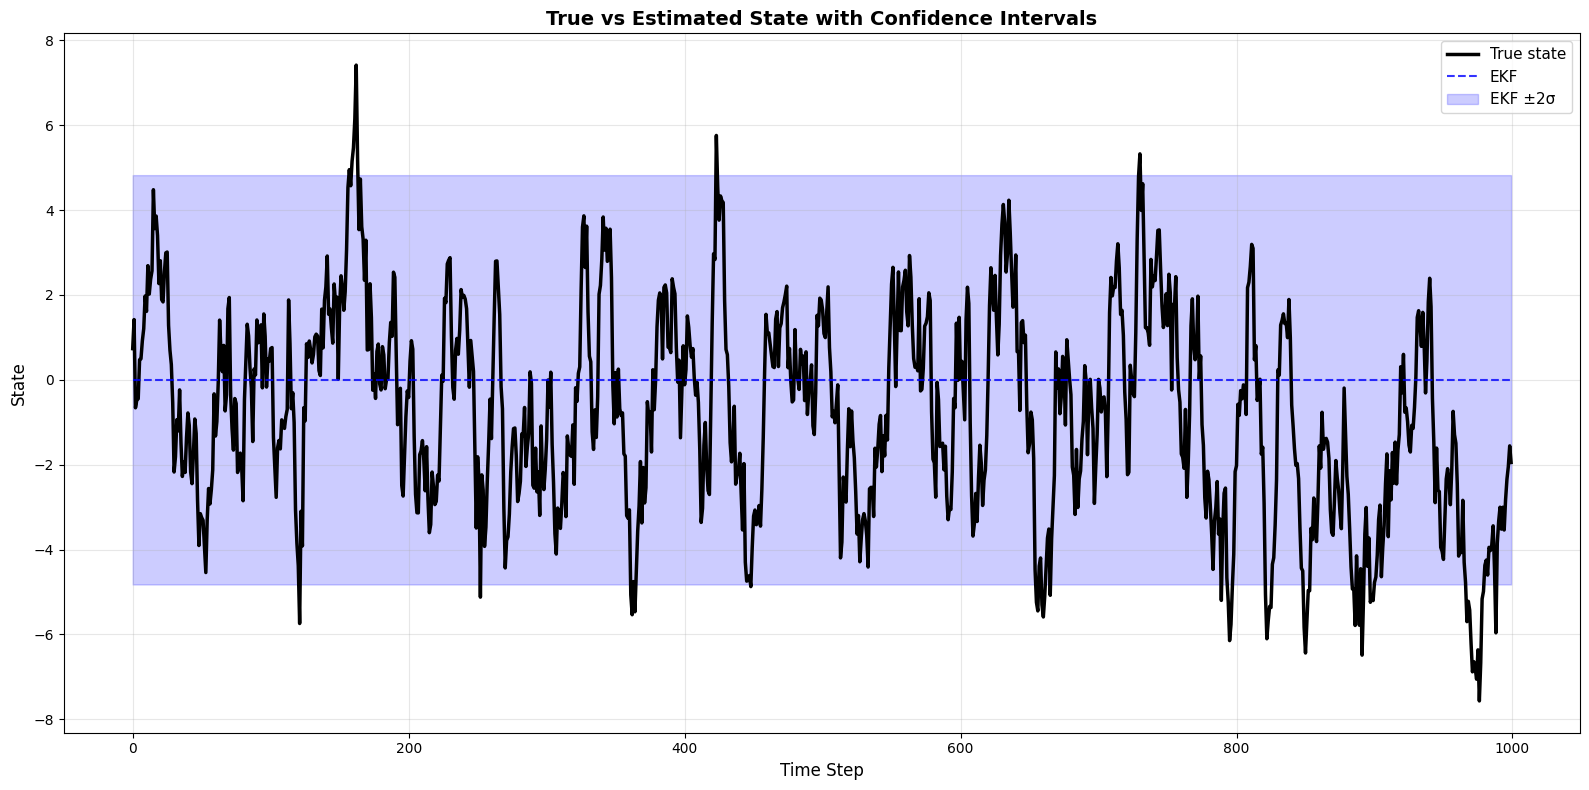

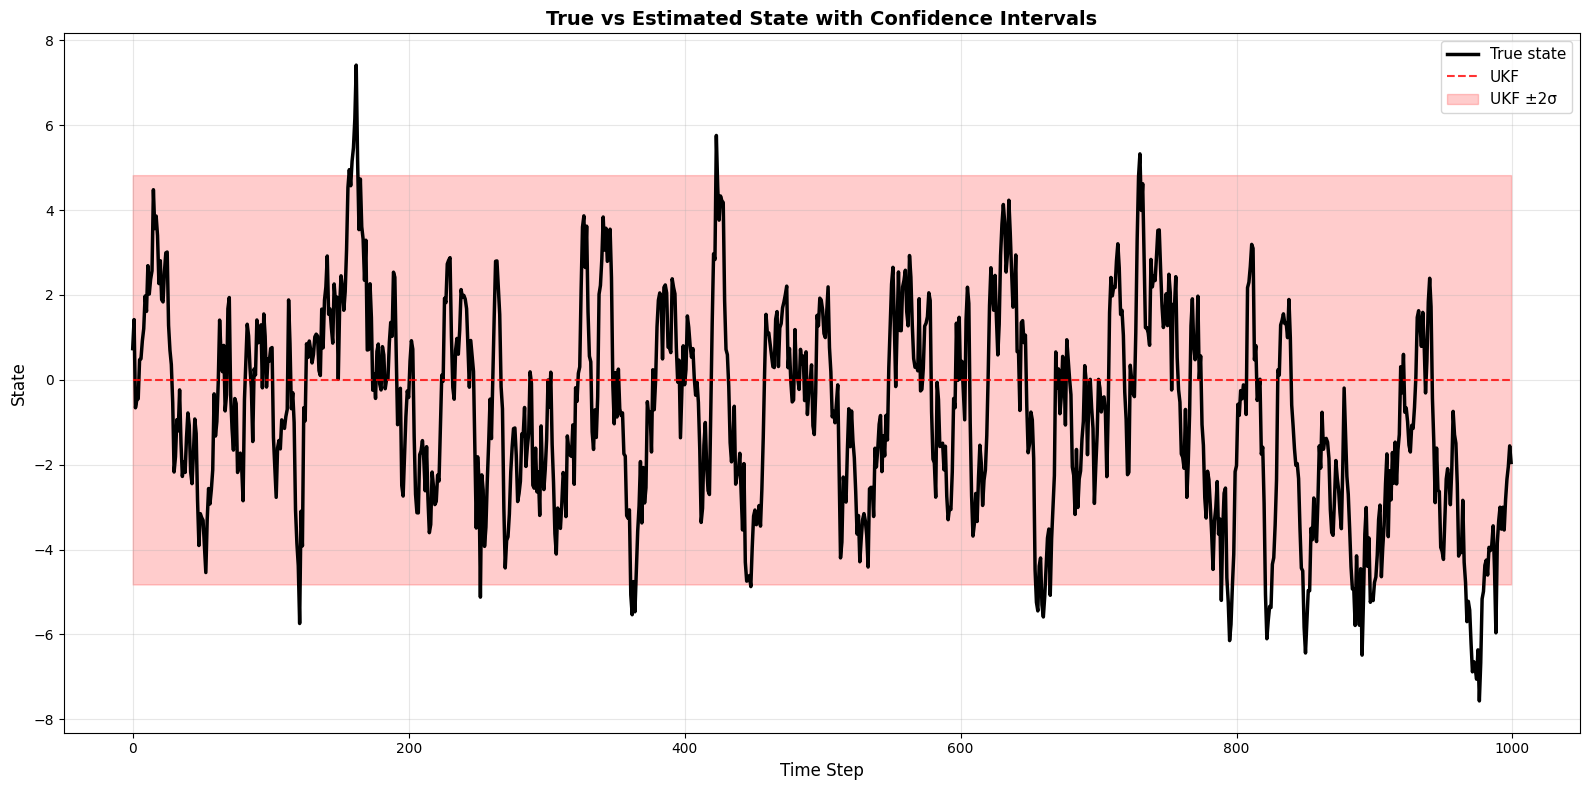

In [11]:
experiment.plot1_true_vs_estimated_with_confidence(
    filter1='EKF', 
    t_min=0, t_max=1000 # Plot full range (can specify e.g., t_min=0, t_max=1000 for subset)
)
experiment.plot1_true_vs_estimated_with_confidence(
     filter2='UKF', 
    t_min=0, t_max=1000  # Plot full range (can specify e.g., t_min=0, t_max=1000 for subset)
)


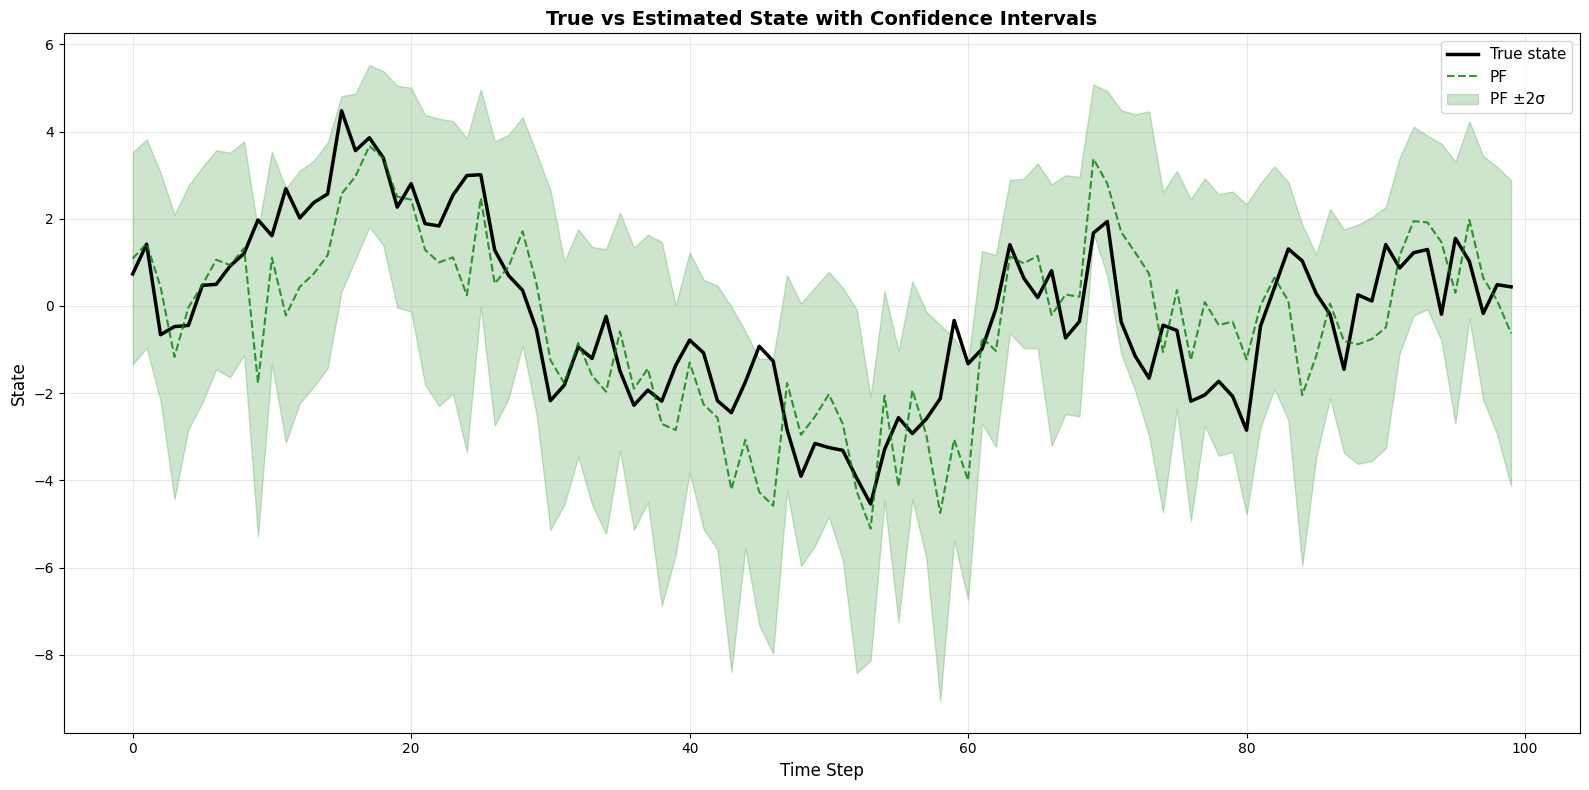

In [8]:
experiment.plot1_true_vs_estimated_with_confidence(
    filter3='PF',
    t_min=0, t_max=100  # Plot full range (can specify e.g., t_min=0, t_max=1000 for subset)
)

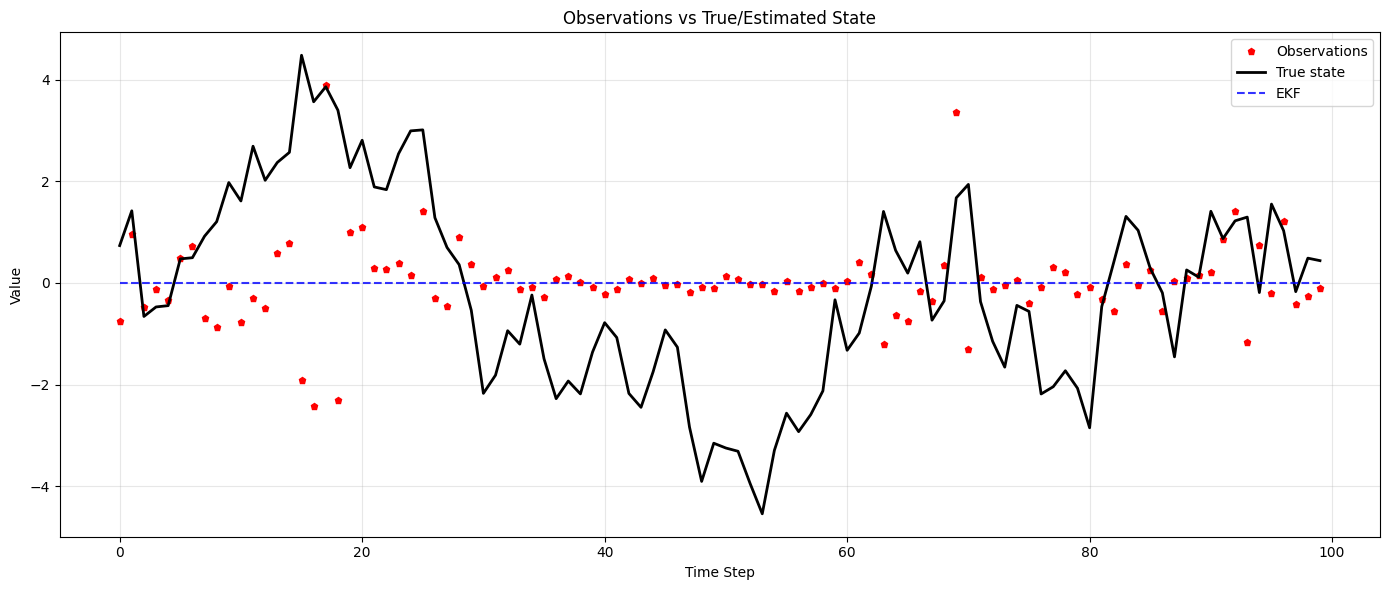

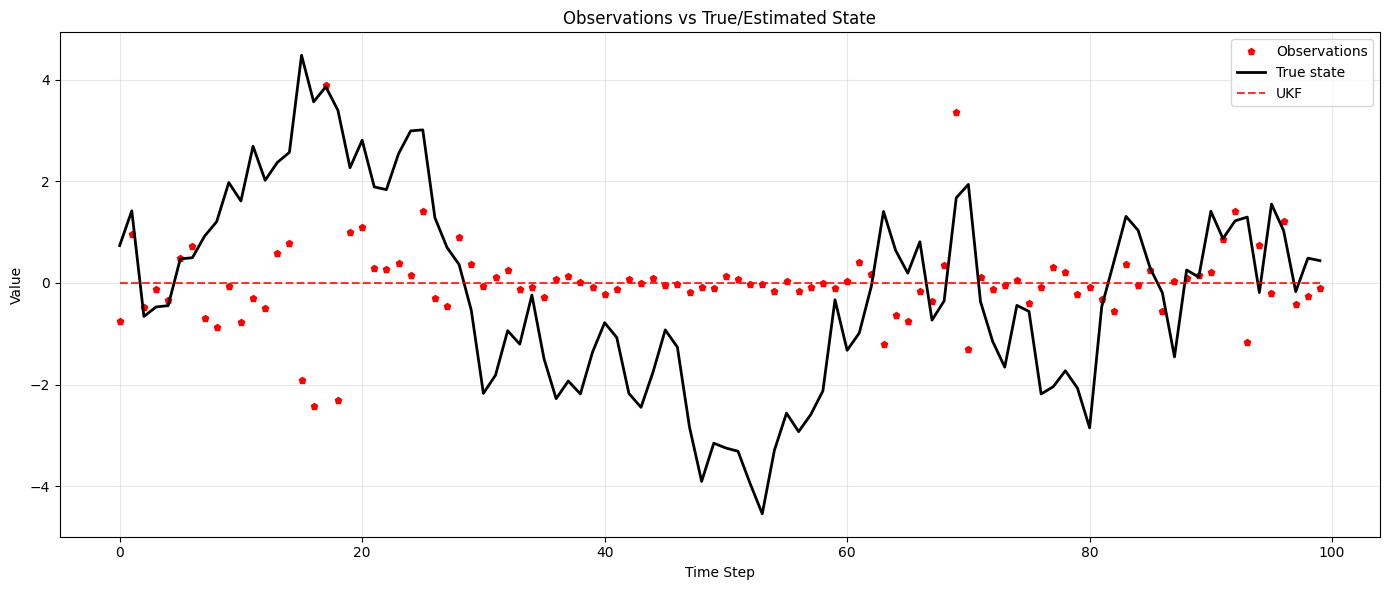

In [12]:
experiment.plot2_true_vs_estimated_with_observations(
    filter1='EKF', 
    t_min=0, t_max=100
)
experiment.plot2_true_vs_estimated_with_observations(
    filter2='UKF', 
    t_min=0, t_max=100
)

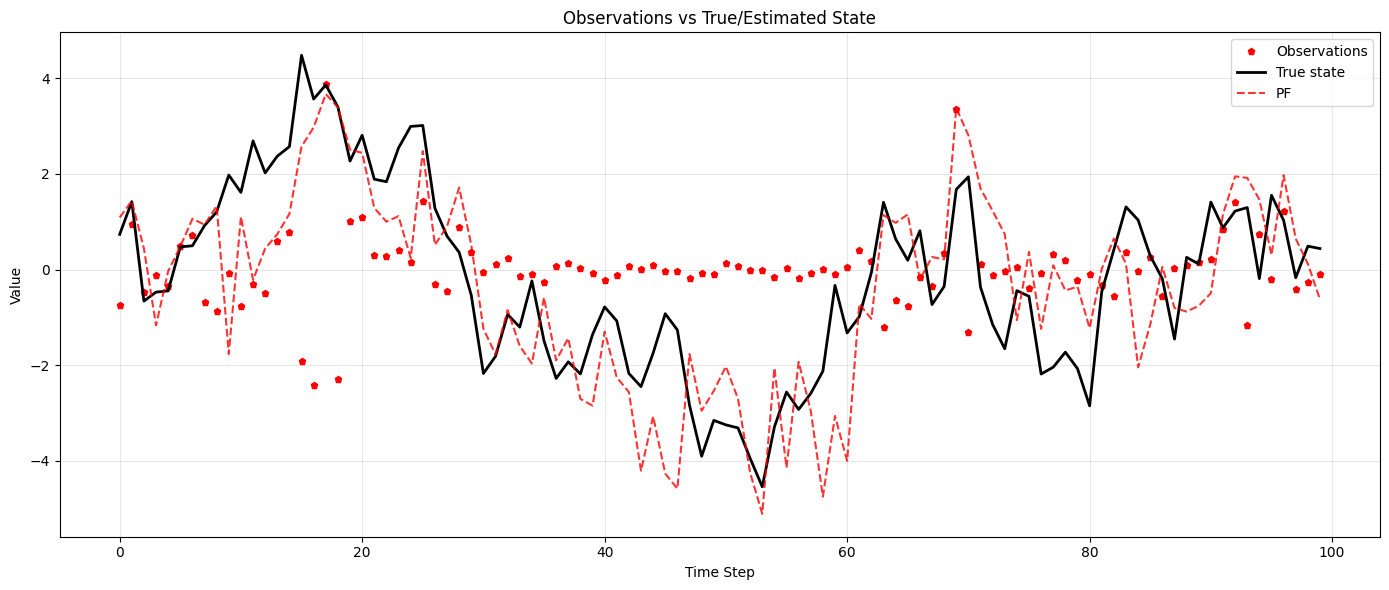

In [15]:
experiment.plot2_true_vs_estimated_with_observations(
    filter2='PF', 
    t_min=0, t_max=100
)

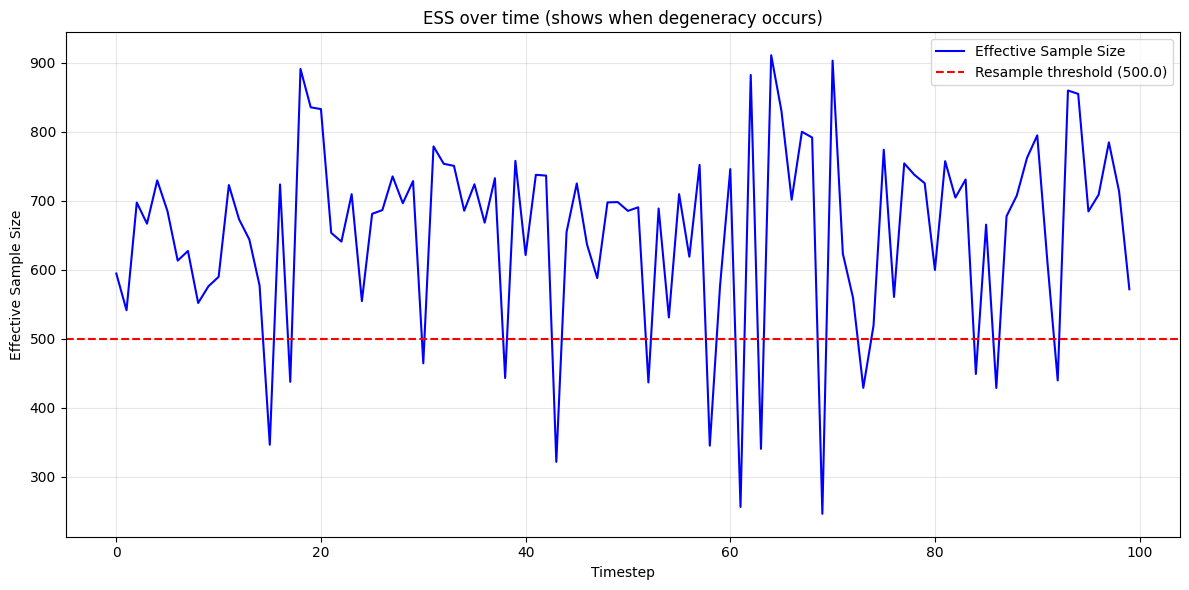

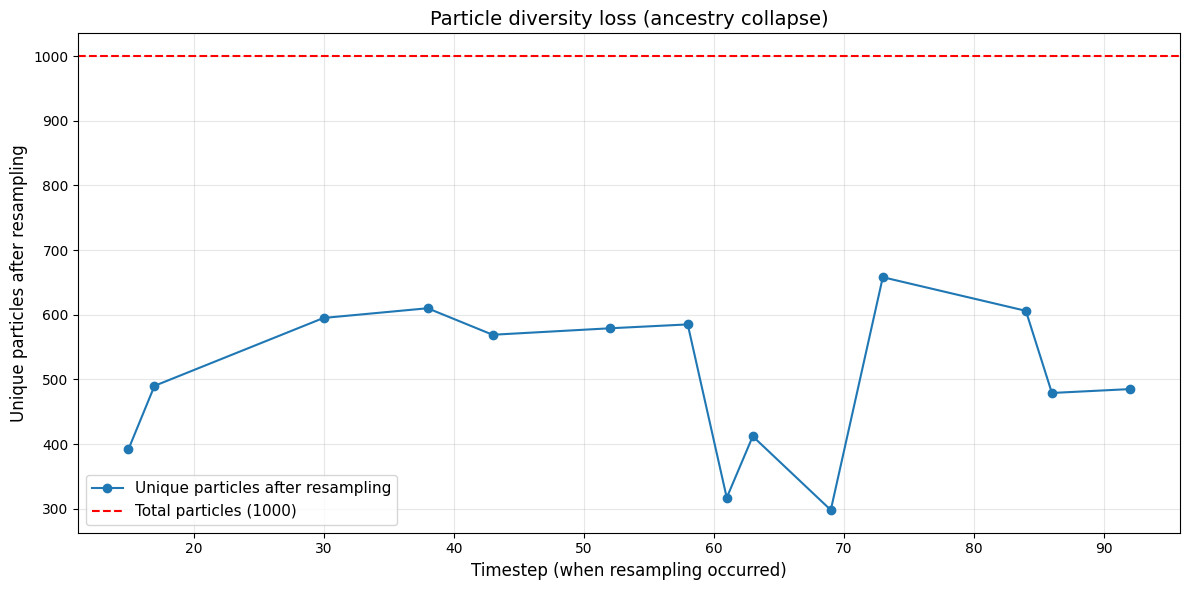

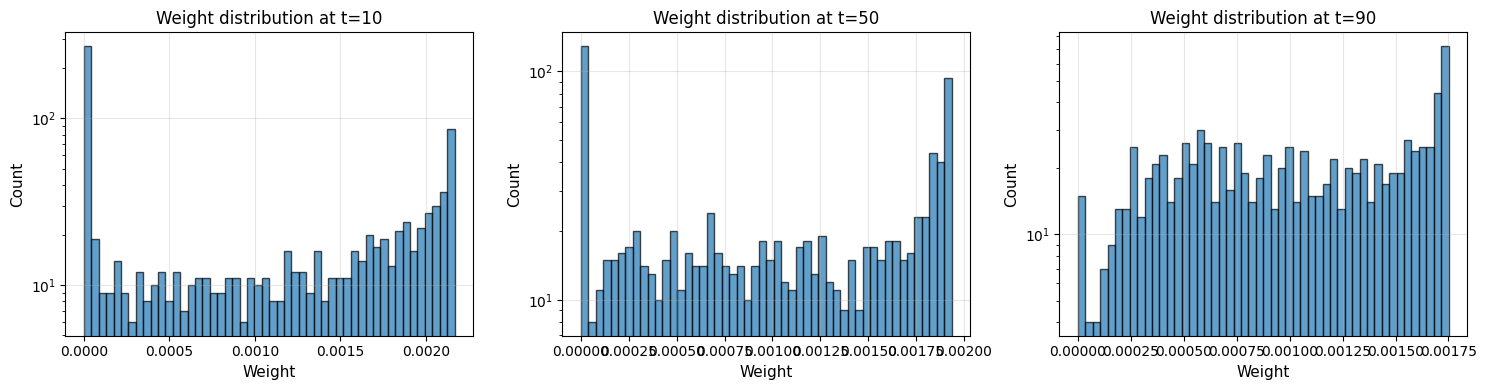

In [13]:
experiment.plot_pf_ess(
    filter_name='PF', 
    t_min=0, t_max=100
)

# Plot unique particles after resampling
experiment.plot_pf_unique_particles(
    filter_name='PF', 
    t_min=0, t_max=100
)

# Plot weight distribution at specific timesteps
experiment.plot_pf_weights_distribution(
    filter_name='PF', 
    timesteps=[10, 50, 90], 
    t_min=0, t_max=100
)

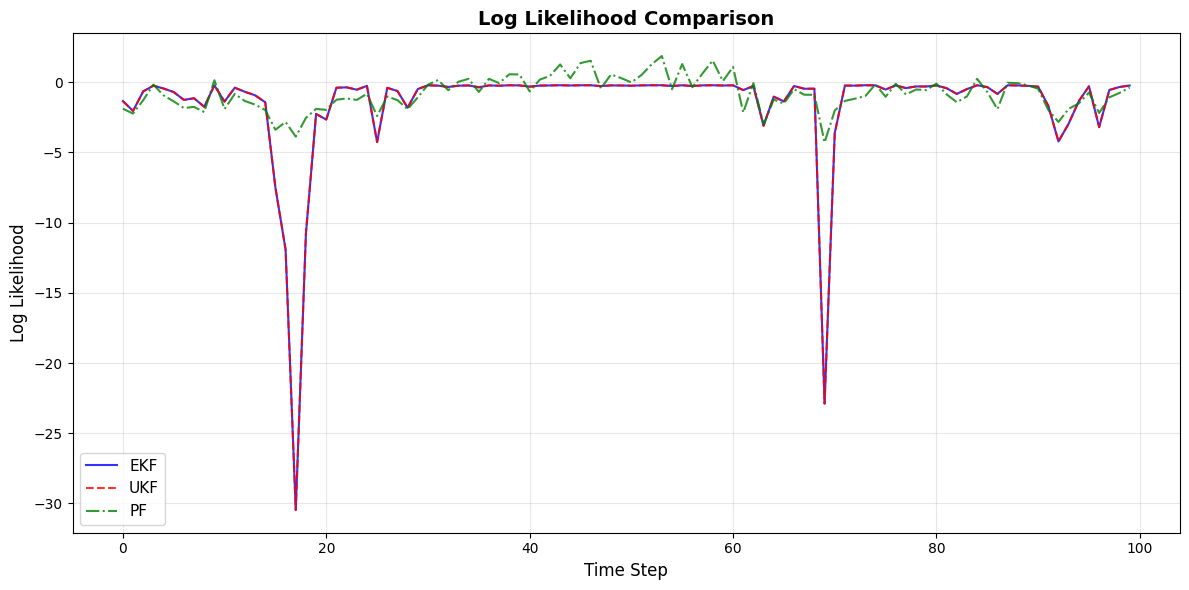

In [14]:
experiment.plot_log_likelihood_comparison(
    filter1='EKF', 
    filter2='UKF', 
    filter3='PF',
    t_min=0, t_max=100
)


Range-Bearing Model - Running filters and measuring execution time:
--------------------------------------------------
EKF: 0.0155 seconds (15.54 ms)
UKF: 0.0264 seconds (26.44 ms)
PF: 24.9490 seconds (24949.01 ms)
--------------------------------------------------
Total time: 24.9910 seconds


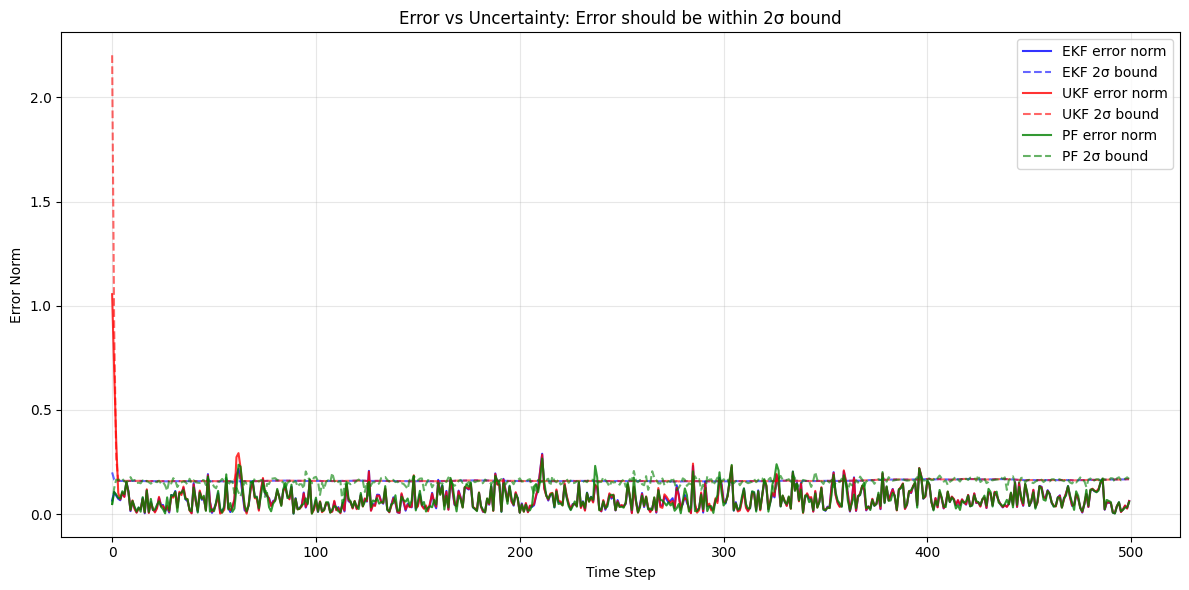

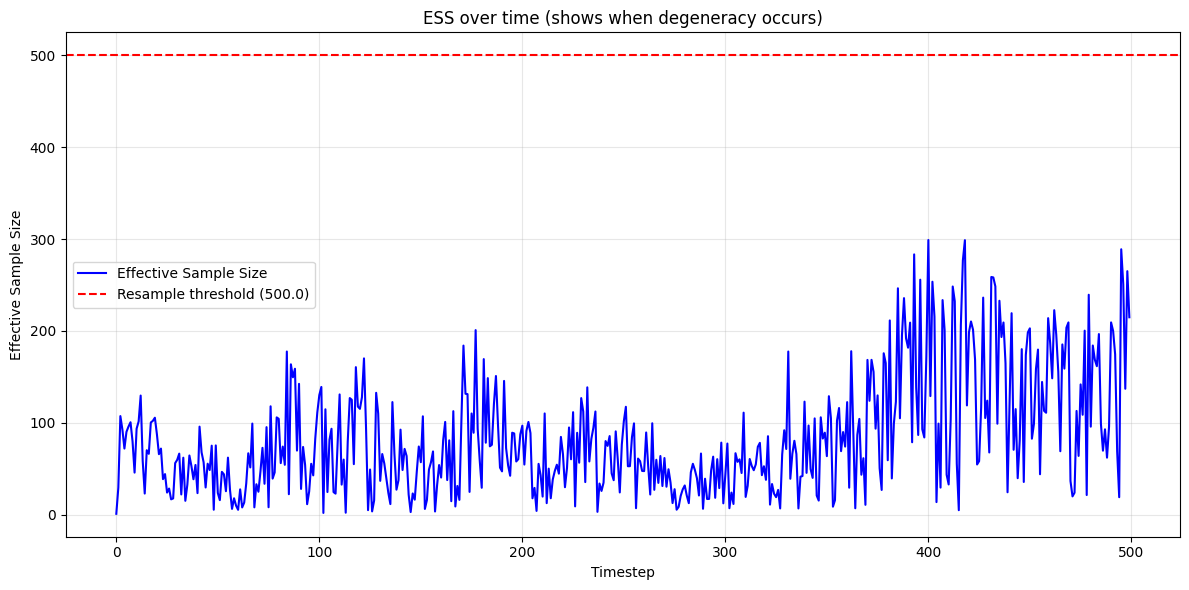

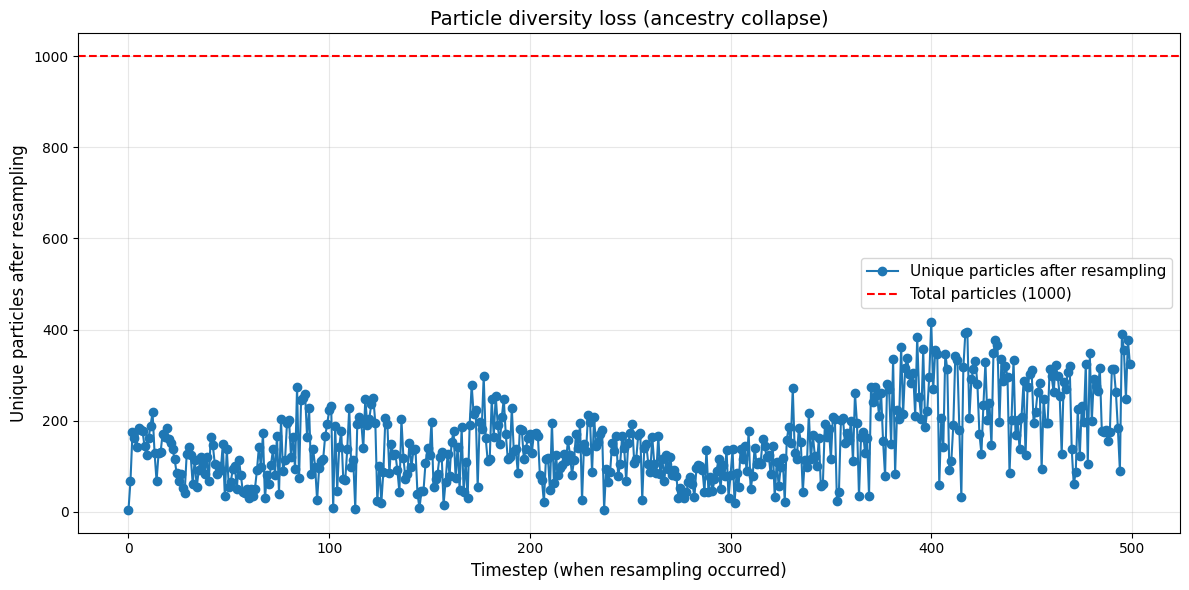

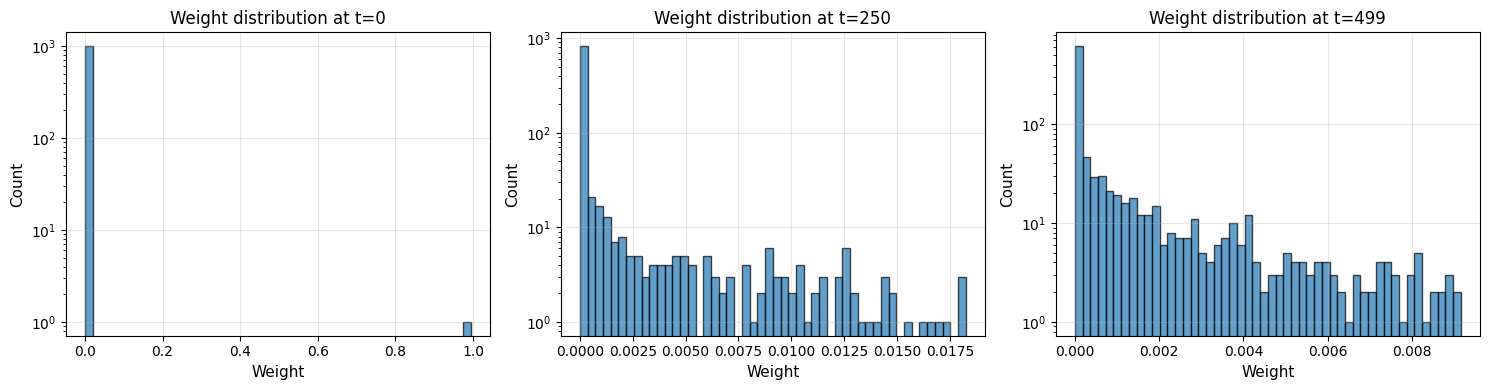

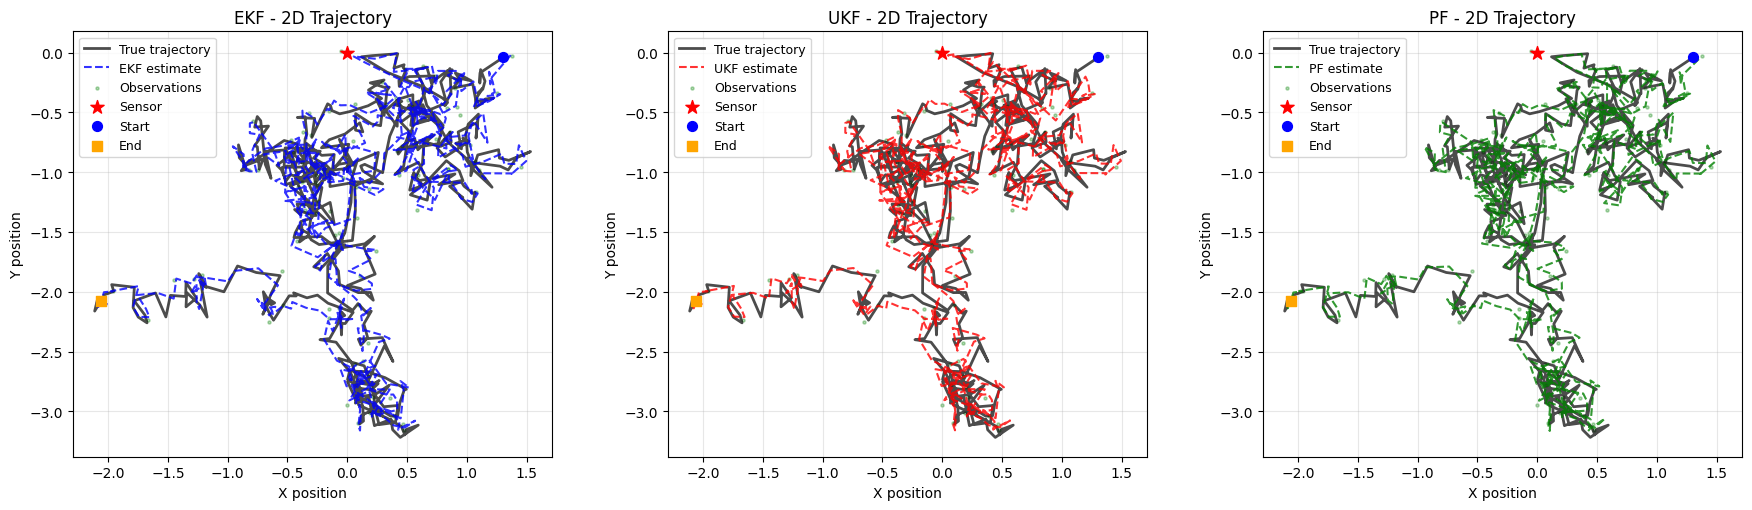

In [ ]:
# ============================================================================
# Range-Bearing Model Experiment
# ============================================================================
# State: 2D position [x, y]
# Observation: [range, bearing]

# Model parameters
sensor_pos = np.array([0.0, 0.0])  # Sensor at origin
sigma_range = 0.1  # Range measurement noise std dev
sigma_bearing = 0.01  # Bearing measurement noise std dev (radians)

# Create model
random_state_rb = np.random.default_rng(42)
model_rb = RangeBearingModel(
    F=None,  # Identity (constant position with noise)
    Q=None,  # Default: 0.01 * I
    sensor_pos=sensor_pos,
    sigma_range=sigma_range,
    sigma_bearing=sigma_bearing,
    mu_0=np.array([1.0, 1.0]),  # Initial position
    Sigma_0=np.eye(2),
    random_state=random_state_rb
)

# Create experiment instance
experiment_rb = NonKalmanExperiment(model=model_rb, T=500, random_state=random_state_rb)

# Generate data
experiment_rb.generate_data()

# Create and run filters with timing
print("\nRange-Bearing Model - Running filters and measuring execution time:")
print("-" * 50)
ekf_time_rb = run_filter_with_timing(experiment_rb, 'EKF')
ukf_time_rb = run_filter_with_timing(experiment_rb, 'UKF')
pf_time_rb = run_filter_with_timing(experiment_rb, 'PF', n_particles=1000, n_threads=None)
print("-" * 50)
print(f"Total time: {ekf_time_rb + ukf_time_rb + pf_time_rb:.4f} seconds")

# Range-Bearing Model - Example plots
# Note: plot1 and plot2 only work for 1D data, so we use plot3 for 2D Range-Bearing model

# Plot 3: Error norms with 2σ bounds (works for any dimension)
experiment_rb.plot3_absolute_error_with_2sigma(
    filter1='EKF', filter2='UKF', filter3='PF',
    filter1_name=None, filter2_name=None, filter3_name=None,
    t_min=None, t_max=None,
    step_size=1
)

# Particle filter specific diagnostics
experiment_rb.plot_pf_ess(filter_name=None, t_min=None, t_max=None, step_size=1)
experiment_rb.plot_pf_unique_particles(filter_name=None, t_min=None, t_max=None, step_size=1)
experiment_rb.plot_pf_weights_distribution(filter_name=None, timesteps=None, t_min=None, t_max=None, step_size=1)



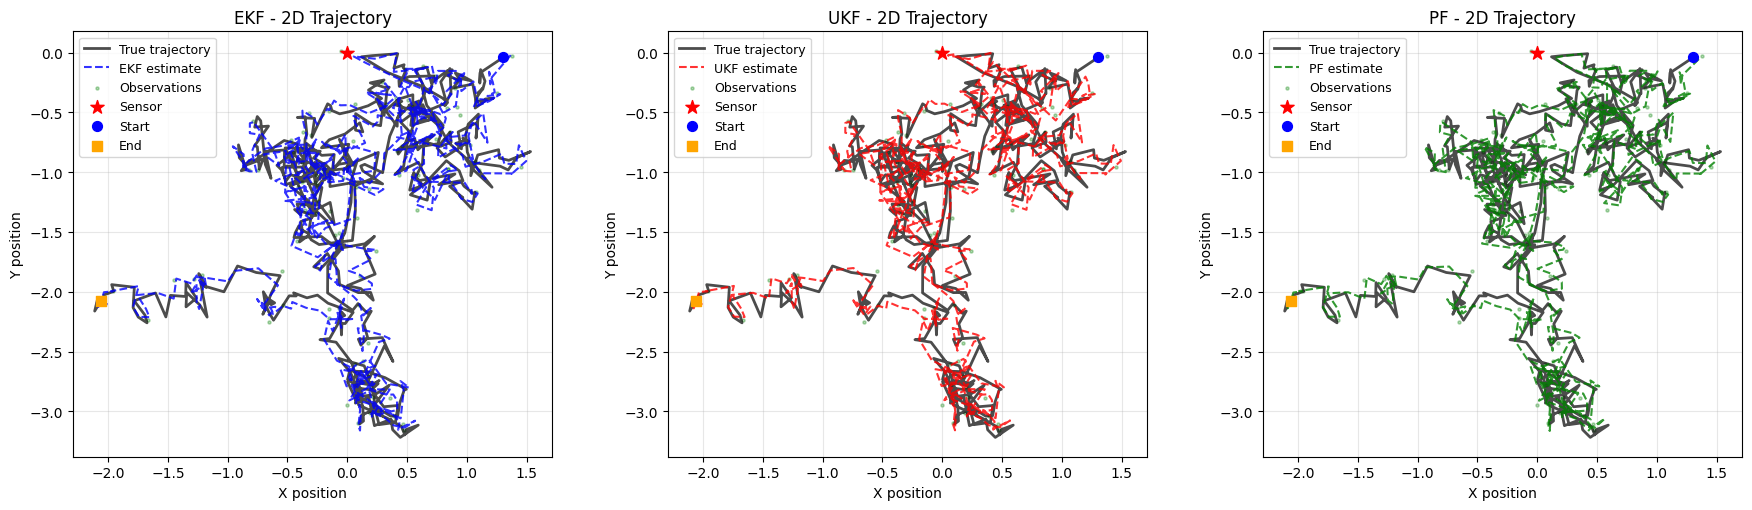

In [12]:

# Range-Bearing Model - 2D Trajectory Visualization
# Plot true and estimated trajectories in 2D space
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Get data
true_states_rb = experiment_rb.true_states
observations_rb = experiment_rb.observations

# Extract range and bearing from observations for visualization
ranges = observations_rb[:, 0]
bearings = observations_rb[:, 1]

# Convert observations to Cartesian for visualization
obs_x = sensor_pos[0] + ranges * np.cos(bearings)
obs_y = sensor_pos[1] + ranges * np.sin(bearings)

# Plot for each filter
filters_to_plot = ['EKF', 'UKF', 'PF']
colors = ['b', 'r', 'g']

for idx, (filter_name, color) in enumerate(zip(filters_to_plot, colors)):
    ax = axes[idx]
    
    if filter_name in experiment_rb.filter_results:
        means = experiment_rb.filter_results[filter_name]['means']
        
        # Plot true trajectory
        ax.plot(true_states_rb[:, 0], true_states_rb[:, 1], 'k-', linewidth=2, label='True trajectory', alpha=0.7)
        
        # Plot estimated trajectory
        ax.plot(means[:, 0], means[:, 1], '--', color=color, linewidth=1.5, 
               label=f'{filter_name} estimate', alpha=0.8)
        
        # Plot observations (downsampled for clarity)
        step = max(1, len(obs_x) // 100)  # Show at most 100 observation points
        ax.scatter(obs_x[::step], obs_y[::step], c='g', s=5, alpha=0.3, label='Observations')
        
        # Plot sensor position
        ax.scatter(sensor_pos[0], sensor_pos[1], c='red', s=100, marker='*', 
                  label='Sensor', zorder=5)
        
        # Plot start and end points
        ax.scatter(true_states_rb[0, 0], true_states_rb[0, 1], c='blue', s=50, 
                  marker='o', label='Start', zorder=4)
        ax.scatter(true_states_rb[-1, 0], true_states_rb[-1, 1], c='orange', s=50, 
                  marker='s', label='End', zorder=4)
        
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        ax.set_title(f'{filter_name} - 2D Trajectory')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()
